In [1]:
import os # Trains on CPU only, use only for model evaluation since loading the entire dataset into the GPU gives OOM
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import keras
from keras.utils import plot_model
from keras.datasets import mnist
from keras.models import Sequential, Model, model_from_json
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, LeakyReLU, Lambda
from keras.layers.merge import concatenate
from keras.constraints import max_norm
from keras import backend as K
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tqdm.keras import TqdmCallback
from skimage.metrics import structural_similarity, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from pathlib import Path

import cv2
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
import pathlib
import gc
import os
import random

import logging
logger = logging.getLogger()
logger.setLevel(100) # Set logging level to disable matplotlib warning when using imshow for normalised data

%matplotlib inline

Using TensorFlow backend.


Define Kodak validation set parameters (512 by 768 pixels) and process validation sets

In [2]:
# Image Parameters
img_width, img_height = 512, 768
noise_factor_low = 5/255
noise_factor_high = 50/255
input_shape = (img_width, img_height, 3)

In [3]:
val_imgs = ['selfsupervised-denoising-master/datasets/kodak_rot/{}'.format(i) for i in os.listdir('selfsupervised-denoising-master/datasets/kodak_rot')]

In [4]:
def read_and_process_image(list_of_images):
    imglist = [] # images
    
    for image in list_of_images:
        imglist.append(cv2.cvtColor(cv2.imread(image, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB))
    
    return imglist

In [5]:
x_val = read_and_process_image(val_imgs)

In [6]:
def plot_images(images, n_plots=5):
    fig, ax = plt.subplots(1, n_plots, figsize=(5*n_plots, 4))

    for i, a in zip(images, ax):
        a.imshow(i)
        a.axis('off')

Plot the Kodak validation dataset.

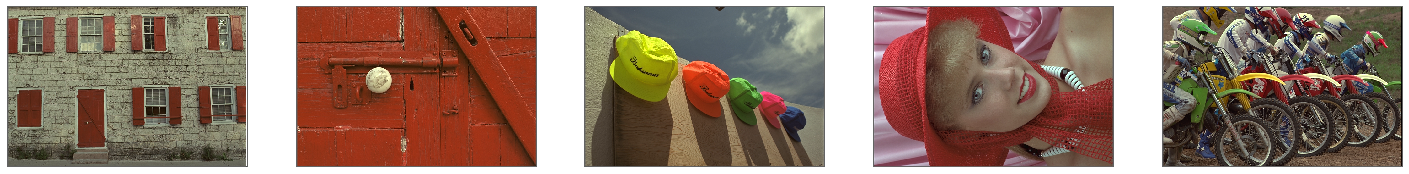

In [7]:
plot_images(x_val)

Normalise the data and add noise. `noise_factor_low` and `noise_factor_high` corresponds to the minimum and maximum standard deviation range for the noise. We will use a range of [5, 50] in this case, so as to match the paper's configuration.

In [8]:
# Normalize data
x_val = [(i / 255) for i in x_val]

In [9]:
operation_seed_counter = 0

def get_seed():
    global operation_seed_counter
    operation_seed_counter += 1
    return operation_seed_counter

# Add Gaussian Noise
def add_gaussian_noise(img_list):
    noised_imgs = [(np.random.normal(0, 1, i.shape)) for i in img_list]
    noised_imgs = [sum(x) for x in zip(img_list, [(random.uniform(noise_factor_low, noise_factor_high) * i) for i in noised_imgs])]
    return [np.clip(i, 0, 1) for i in noised_imgs]

# Add Uniform Noise
def add_uniform_noise(img_list):
    noised_imgs = [(np.random.uniform(0, 1, i.shape)) for i in img_list]
    noised_imgs = [sum(x) for x in zip(img_list, [(random.uniform(noise_factor_low, noise_factor_high) * i) for i in noised_imgs])]
    return [np.clip(i, 0, 1) for i in noised_imgs]

# Add Poisson Noise
def add_poisson_noise(img_list):
    noised_imgs = [(np.random.poisson(1, i.shape)) for i in img_list]
    noised_imgs = [sum(x) for x in zip(img_list, [(random.uniform(noise_factor_low, noise_factor_high) * i) for i in noised_imgs])]
    return [np.clip(i, 0, 1) for i in noised_imgs]

# Add Impulse Noise
def add_impulse_noise(img_list, min_a=0, max_a=1):
    num_samples = len(img_list)
    msh = [num_samples, img_width, img_height, 1]
    alpha = tf.random.uniform(shape=[num_samples, 1, 1, 1], minval=min_a, maxval=max_a, seed=get_seed())
    keep_mask = tf.where(tf.random.uniform(shape=msh, seed=get_seed()) >= tf.ones(shape=msh) * alpha, tf.ones(shape=msh), tf.zeros(shape=msh))
    noise = tf.random.uniform(shape=tf.shape(img_list), seed=get_seed())
    return (img_list * keep_mask + noise * (1.0 - keep_mask)).numpy()

In [10]:
x_val_gauss = add_gaussian_noise(x_val)
x_val_gauss_targets = add_gaussian_noise(x_val)

x_val_poiss = add_poisson_noise(x_val)
x_val_poiss_targets = add_poisson_noise(x_val)

x_val_imp = add_impulse_noise(x_val)
x_val_imp_targets = add_impulse_noise(x_val)

In [11]:
#if not os.path.exists('pure_set'):
#    os.makedirs('pure_set')

# if not os.path.exists('gaussian_pg'):
#     os.makedirs('gaussian_pg')
    
# if not os.path.exists('poisson_pg'):
#     os.makedirs('poisson_pg')
    
# if not os.path.exists('impulse_pg'):
#     os.makedirs('impulse_pg')

In [12]:
# for i in range(0, len(x_val)):
#     #img_s = 255*x_val[i].astype(np.float32)
#     img_g = 255*x_val_gauss[i].astype(np.float32)
#     img_p = 255*x_val_poiss[i].astype(np.float32)
#     img_i = 255*x_val_imp[i].astype(np.float32)
#     #cv2.imwrite('pure_set/pure%s.jpg' % i, cv2.cvtColor(img_s, cv2.COLOR_RGB2BGR))
#     cv2.imwrite('gaussian_pg/gaussian_noise%s.jpg' % i, cv2.cvtColor(img_g, cv2.COLOR_RGB2BGR))
#     cv2.imwrite('poisson_pg/poisson_noise%s.jpg' % i, cv2.cvtColor(img_p, cv2.COLOR_RGB2BGR))
#     cv2.imwrite('impulse_pg/impulse_noise%s.jpg' % i, cv2.cvtColor(img_i, cv2.COLOR_RGB2BGR))

Plot the noisy validation images for all three noise profiles for visualisation.

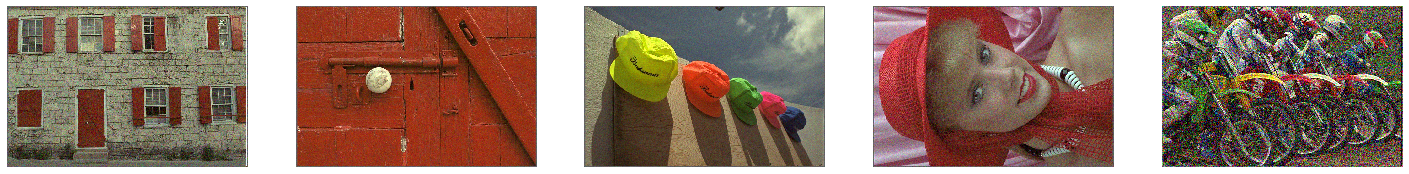

In [13]:
plot_images(x_val_gauss)  # Gaussian Noise

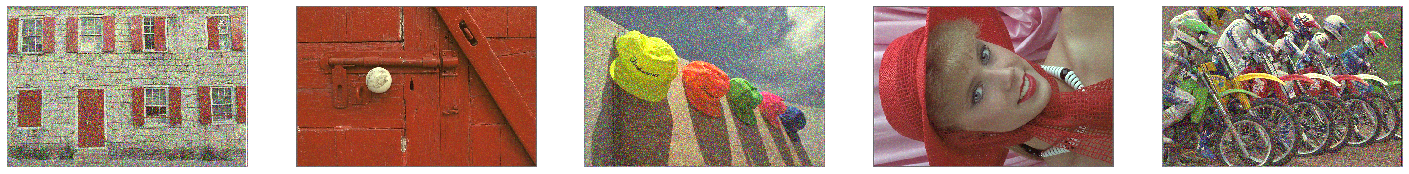

In [14]:
plot_images(x_val_poiss)  # Poisson Noise

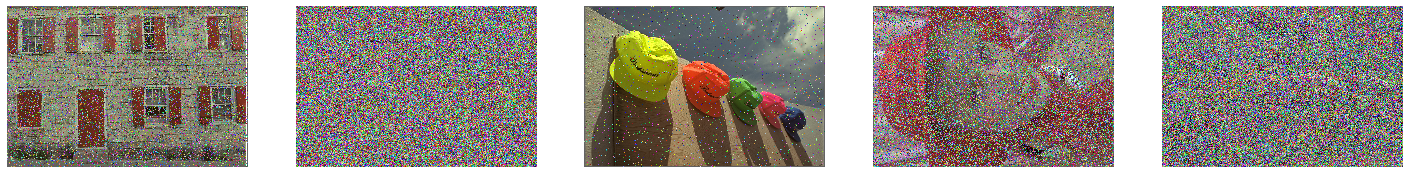

In [15]:
plot_images(x_val_imp)    # Impulse Noise

The below is our implementation for the paper's autoencoder u-net model, with optional blind spot.

In [16]:
# Backbone autoencoder network, optional blind spot.
blindspot = False

def up(n):
    s = tf.shape(n)
    s = [-1, n.shape[1], s[2], s[3]]
    n = tf.reshape(n, [s[0], s[1], s[2], 1, s[3], 1])
    n = tf.tile(n, [1, 1, 1, 2, 1, 2])
    n = tf.reshape(n, [s[0], s[1], s[2] * 2, s[3] * 2])
    return n

def down(n):
    n = tf.pad(n[:, :, :-1, :], [[0, 0], [0, 0], [1, 0], [0, 0]])
    n = tf.nn.max_pool(n, ksize=[1, 1, 2, 2], strides=[1, 1, 2, 2], padding='SAME', data_format='NHWC')
    return n

def rotate(x, angle):
    if   angle == 0:   return x
    elif angle == 90:  return tf.transpose(x[:, :, :, ::-1], [0, 1, 2, 3])
    elif angle == 180: return x[:, :, ::-1, ::-1]
    elif angle == 270: return tf.transpose(x[:, :, ::-1, :], [0, 1, 2, 3])

def concat(layers):
    return tf.concat(layers, axis=3)

def input_rotation(n):
    return tf.concat([rotate(n, a) for a in [0, 90, 180, 270]], axis=3)

def output_rotation(n):
    return tf.concat([rotate(n, a) for a in [0, 270, 180, 90]], axis=3)

def rotate90(x):
    return tf.transpose(x[:, :, :, ::-1], [0, 1, 2, 3])

def rotate180(x):
    return x[:, :, ::-1, ::-1]

def rotate270(x):
    return tf.transpose(x[:, :, ::-1, :], [0, 1, 2, 3])

def shift_and_pad(x):
    return tf.pad(x[:, :, :-1, :], [[0, 0], [0, 0], [1, 0], [0, 0]])

def split(x):
    return tf.split(x, 4, axis=3)

In [17]:
# Input stage
inputs = Input(input_shape)

if not blindspot:
    x = inputs
else:
    x = Lambda(input_rotation, name='rotate_inputs')(inputs)

# Encoder part
pool0 = x
x = Conv2D(48, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='enc_conv0')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(48, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='enc_conv1')(x)
x = LeakyReLU(alpha=0.1)(x)  
x = Lambda(shift_and_pad)(x)
x = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding = 'same', data_format='channels_last', name='pool1')(x); pool1 = x

x = Conv2D(48, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='enc_conv2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Lambda(shift_and_pad)(x)
x = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding = 'same', data_format='channels_last', name='pool2')(x); pool2 = x

x = Conv2D(48, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='enc_conv3')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Lambda(shift_and_pad)(x)
x = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding = 'same', data_format='channels_last', name='pool3')(x); pool3 = x

x = Conv2D(48, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='enc_conv4')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Lambda(shift_and_pad)(x)
x = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding = 'same', data_format='channels_last', name='pool4')(x); pool4 = x

x = Conv2D(48, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='enc_conv5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Lambda(shift_and_pad)(x)
x = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding = 'same', data_format='channels_last', name='pool5')(x); pool5 = x

x = Conv2D(48, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='enc_conv6')(x)

# Decoder part
x = UpSampling2D(size = (1, 2), name='upsample5')(x)
x = concatenate([x, pool4], axis=3, name='concat5')
x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv5a')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv5b')(x)
x = LeakyReLU(alpha=0.1)(x)

x = UpSampling2D(size = (1, 2), name='upsample4')(x)
x = concatenate([x, pool3], axis=3, name='concat4')
x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv4a')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv4b')(x)
x = LeakyReLU(alpha=0.1)(x)

x = UpSampling2D(size = (1, 2), name='upsample3')(x)
x = concatenate([x, pool2], axis=3, name='concat3')
x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv3a')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv3b')(x)
x = LeakyReLU(alpha=0.1)(x)

x = UpSampling2D(size = (1, 2), name='upsample2')(x)
x = concatenate([x, pool1], axis=3, name='concat2')
x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv2a')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv2b')(x)
x = LeakyReLU(alpha=0.1)(x)

x = UpSampling2D(size = (1, 2), name='upsample1')(x)
x = concatenate([x, pool0], axis=3, name='concat1')

# Output stages

if blindspot:
    # Blind-spot output stages
    x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv1a')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv1b')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Lambda(shift_and_pad, name='shift_and_pad')(x)
    x = Lambda(split, name='split')(x)
    rot90s = Lambda(rotate90)(x[3])
    rot180s = Lambda(rotate180)(x[2])
    rot270s = Lambda(rotate270)(x[1])
    x = concatenate([x[0], rot90s, rot180s, rot270s], axis=3)   # Combine on channel axis.
    x = Conv2D(96*4, 1, strides=(1, 1), padding = 'same', data_format='channels_last', name='nin_a')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(96, 1, strides=(1, 1), padding = 'same', data_format='channels_last', name='nin_b')(x)
    x = LeakyReLU(alpha=0.1)(x)
    outputs = Conv2D(3, 1, activation = 'linear', name='nin_c')(x)

else:
    # Baseline network with postprocessing layers -- keep feature maps and distill with 1x1 convolutions
    x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv1a')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv1b')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(96*4, 1, strides=(1, 1), padding = 'same', data_format='channels_last', name='nin_a')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(96, 1, strides=(1, 1), padding = 'same', data_format='channels_last', name='nin_b')(x)
    x = LeakyReLU(alpha=0.1)(x)
    outputs = Conv2D(3, 1, activation = 'linear', name='nin_c')(x)

model_n2c_gauss = Model(input = inputs, output = outputs)
model_n2n_gauss = Model(input = inputs, output = outputs)
model_n2c_poiss = Model(input = inputs, output = outputs)
model_n2n_poiss = Model(input = inputs, output = outputs)
model_n2c_imp = Model(input = inputs, output = outputs)
model_n2n_imp = Model(input = inputs, output = outputs)

# Summarize layers
# print(model.summary())

# Plot model architecture
# plot_model(model, to_file='shared_input_layer.png')

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:104: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ni...)`
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ni...)`
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:106: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ni...)`
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:107: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ni...)`
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:108: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ni...)`
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:109: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("

We define a set of different metrics for comparison and to measure the model's performance.

In [18]:
def MSE(pure, target):
    return mean_squared_error(pure, target)

def PSNR(pure, target):
    max_pixel = 1.0
    return (tf.image.psnr(pure, target, max_pixel))

def SSIM(pure, target):
    return tf.image.ssim(pure, target, max_val = 1)

def SSIM_cv(pure, target):
    return structural_similarity(pure, target, dynamic_range=1, multichannel=True)

Using the models we trained on the paper's ILSVR ImageNet dataset (1000 images), we run the noisy validation images into each of the six models we trained for denoising.

In [19]:
# Generate denoised images (Gaussian N2C), Validation Set
model_n2c_gauss.load_weights(str(Path('./n2c_gauss_5_50.h5')))
denoised_images_g_n2c = np.clip(model_n2c_gauss.predict(np.array(x_val_gauss)), 0, 1)

In [20]:
# Generate denoised images (Gaussian N2N), Validation Set
model_n2n_gauss.load_weights(str(Path('./n2n_gauss_5_50.h5')))
denoised_images_g_n2n = np.clip(model_n2n_gauss.predict(np.array(x_val_gauss)), 0, 1)

In [21]:
# Generate denoised images (Poisson N2C), Validation Set
model_n2c_poiss.load_weights(str(Path('./n2c_poiss_5_50.h5')))
denoised_images_p_n2c = np.clip(model_n2c_poiss.predict(np.array(x_val_poiss)), 0, 1)

In [22]:
# Generate denoised images (Poisson N2N), Validation Set
model_n2n_poiss.load_weights(str(Path('./n2n_poiss_5_50.h5')))
denoised_images_p_n2n = np.clip(model_n2n_poiss.predict(np.array(x_val_poiss)), 0, 1)

In [23]:
# Generate denoised images (Impulse N2C), Validation Set
model_n2c_imp.load_weights(str(Path('./n2c_imp_0_100.h5')))
denoised_images_i_n2c = np.clip(model_n2c_imp.predict(np.array(x_val_imp)), 0, 1)

In [24]:
# Generate denoised images (Impulse N2N), Validation Set
model_n2n_imp.load_weights(str(Path('./n2n_imp_0_100.h5')))
denoised_images_i_n2n = np.clip(model_n2n_imp.predict(np.array(x_val_imp)), 0, 1)

In [25]:
all_results = [denoised_images_g_n2c, denoised_images_g_n2n, denoised_images_p_n2c, denoised_images_p_n2n, \
               denoised_images_i_n2c, denoised_images_i_n2n]

In [26]:
# if not os.path.exists('denoised_gauss_n2c'):
#     os.makedirs('denoised_gauss_n2c')

# if not os.path.exists('denoised_gauss_n2n'):
#     os.makedirs('denoised_gauss_n2n')

# if not os.path.exists('denoised_imp_n2c'):
#     os.makedirs('denoised_imp_n2c')
    
# if not os.path.exists('denoised_imp_n2n'):
#     os.makedirs('denoised_imp_n2n')

# if not os.path.exists('denoised_poiss_n2c'):
#     os.makedirs('denoised_poiss_n2c')
    
# if not os.path.exists('denoised_poiss_n2n'):
#     os.makedirs('denoised_poiss_n2n')

In [27]:
# for i in range(0, len(x_val)):
#     img_g_n2c = 255*denoised_images_g_n2c[i].astype(np.float32)
#     img_g_n2n = 255*denoised_images_g_n2n[i].astype(np.float32)
#     img_p_n2c = 255*denoised_images_p_n2c[i].astype(np.float32)
#     img_p_n2n = 255*denoised_images_p_n2n[i].astype(np.float32)
#     img_i_n2c = 255*denoised_images_i_n2c[i].astype(np.float32)
#     img_i_n2n = 255*denoised_images_i_n2n[i].astype(np.float32)
#     cv2.imwrite('denoised_gauss_n2c/denoised_gauss_n2c%s.jpg' % i, cv2.cvtColor(img_g_n2c, cv2.COLOR_RGB2BGR))
#     cv2.imwrite('denoised_gauss_n2n/denoised_gauss_n2n%s.jpg' % i, cv2.cvtColor(img_g_n2n, cv2.COLOR_RGB2BGR))
#     cv2.imwrite('denoised_imp_n2c/denoised_imp_n2c%s.jpg' % i, cv2.cvtColor(img_i_n2c, cv2.COLOR_RGB2BGR))
#     cv2.imwrite('denoised_imp_n2n/denoised_imp_n2n%s.jpg' % i, cv2.cvtColor(img_i_n2n, cv2.COLOR_RGB2BGR))
#     cv2.imwrite('denoised_poiss_n2c/denoised_poiss_n2n%s.jpg' % i, cv2.cvtColor(img_p_n2c, cv2.COLOR_RGB2BGR))
#     cv2.imwrite('denoised_poiss_n2n/denoised_poiss_n2n%s.jpg' % i, cv2.cvtColor(img_p_n2n, cv2.COLOR_RGB2BGR))

Define a set of different metrics for measuring each model's performance.

In [28]:
# Calculate Average MSE
def calc_avg_mse(true_imgs, measured_imgs):
    mse_summed = 0
    for i in range(0, len(measured_imgs)):
        mse_summed += MSE(true_imgs[i], measured_imgs[i])
    return (mse_summed/len(measured_imgs))

# Calculate Average PSNR
def calc_avg_psnr(true_imgs, measured_imgs):
    pnsr_summed = 0
    for i in range(0, len(measured_imgs)):
        pnsr_summed += PSNR(true_imgs[i], measured_imgs[i])
    return (pnsr_summed.numpy()/len(measured_imgs))

# Calculate Average Structural Similarity Index
def calc_avg_ssim(true_imgs, measured_imgs):
    ssim_summed = 0
    for i in range(0, len(measured_imgs)):
        ssim_summed += SSIM_cv(true_imgs[i], measured_imgs[i])
    return (ssim_summed/len(measured_imgs))

Calculate and compare average metrics for validation with the paper's results.

In [29]:
all_results_index = ['gauss5_50_n2c', 'gauss5_50_n2n', 'poisson5_50_n2c', 'poisson5_50_n2n', 'impulse0_100_n2c', 'impulse0_100_n2n']
denoised_psnrs = pd.DataFrame({"Denoised Images (PSNR)": [calc_avg_psnr(x_val, i) for i in all_results]})
denoised_mses = pd.DataFrame({"Denoised Images (MSE)": [calc_avg_mse(x_val, i) for i in all_results]})
denoised_ssims = pd.DataFrame({"Denoised Images (SSIM)": [calc_avg_ssim(x_val, i) for i in all_results]}) 
compare_denoised = pd.concat([denoised_psnrs, denoised_mses, denoised_ssims], axis=1)
compare_denoised.index = all_results_index

C:\Anaconda\lib\site-packages\skimage\metrics\_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


Resulting metrics from the denoised Kodak validation images using our coded implementation of the paper's models.

In [30]:
compare_denoised.round(3)

Denoised Images (PSNR)  Denoised Images (MSE)  \
gauss5_50_n2c                     32.021                  0.001   
gauss5_50_n2n                     30.974                  0.001   
poisson5_50_n2c                   33.493                  0.001   
poisson5_50_n2n                   20.458                  0.009   
impulse0_100_n2c                  24.185                  0.009   
impulse0_100_n2n                  17.714                  0.021   

                  Denoised Images (SSIM)  
gauss5_50_n2c                      0.933  
gauss5_50_n2n                      0.927  
poisson5_50_n2c                    0.960  
poisson5_50_n2n                    0.893  
impulse0_100_n2c                   0.790  
impulse0_100_n2n                   0.720

Merging the results from the paper, we can compare our implementation against the paper's models.

In [31]:
compare_denoised_paper=pd.read_csv('./denoised_metrics_from_paper.csv', sep=',', index_col=0)  

In [32]:
compare_both = compare_denoised_paper.merge(compare_denoised, left_index=True, right_index=True).iloc[:,0:4:3]
compare_both.columns = ['Denoised Images, Paper (PSNR)', 'Denoised Images, Ours (PSNR)']
compare_both['PSNR Difference'] = compare_both.iloc[:,1] - compare_both.iloc[:,0]
#compare_both['Percentage Difference'] = abs(compare_both.iloc[:,2])/compare_both.iloc[:,0] * 100
compare_both['Ours Better?'] = compare_both.iloc[:,2].map(lambda x: 'Yes' if x>0 else 'No')
compare_both.round(3)

Denoised Images, Paper (PSNR)  Denoised Images, Ours (PSNR)  \
gauss5_50_n2n                            33.437                        30.974   
gauss5_50_n2c                            33.444                        32.021   
poisson5_50_n2n                          30.911                        20.458   
poisson5_50_n2c                          30.915                        33.493   
impulse0_100_n2n                         33.092                        17.714   
impulse0_100_n2c                         33.327                        24.185   

                  PSNR Difference Ours Better?  
gauss5_50_n2n              -2.463           No  
gauss5_50_n2c              -1.423           No  
poisson5_50_n2n           -10.453           No  
poisson5_50_n2c             2.578          Yes  
impulse0_100_n2n          -15.378           No  
impulse0_100_n2c           -9.142           No

In [33]:
compare_both.to_csv(str(Path('./denoised_metrics_from_both.csv')), sep=',')

In [34]:
all_noisy = [x_val_gauss, x_val_poiss, x_val_imp]
noisy_psnrs = pd.DataFrame({"Noisy Images (PSNR)": [calc_avg_psnr(x_val, i) for i in all_noisy]})
noisy_mses = pd.DataFrame({"Noisy Images (MSE)": [calc_avg_mse(x_val, i) for i in all_noisy]})
noisy_ssims = pd.DataFrame({"Noisy Images (SSIM)": [calc_avg_ssim(x_val, i) for i in all_noisy]}) 
compare_noisy = pd.concat([noisy_psnrs, noisy_mses, noisy_ssims], axis=1)
compare_noisy.index = ['x_val_gauss', 'x_val_poiss', 'x_val_imp']

C:\Anaconda\lib\site-packages\skimage\metrics\_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


Metrics from the noisy images as measured against the pure ground truth set.

In [35]:
compare_noisy.round(3)

Noisy Images (PSNR)  Noisy Images (MSE)  Noisy Images (SSIM)
x_val_gauss               22.093               0.012                0.543
x_val_poiss               18.171               0.025                0.503
x_val_imp                 13.147               0.069                0.211

Some visualisations for the results.

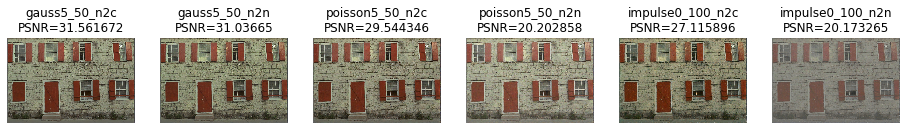

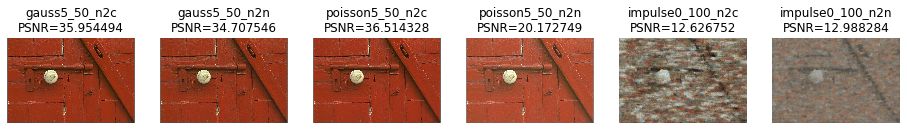

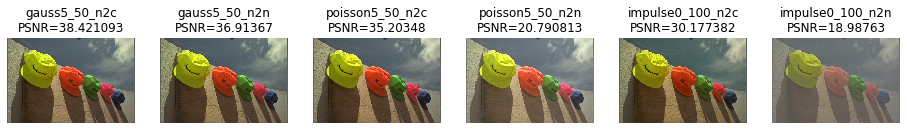

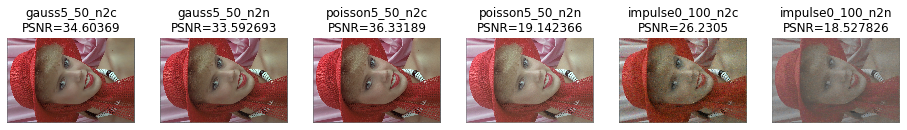

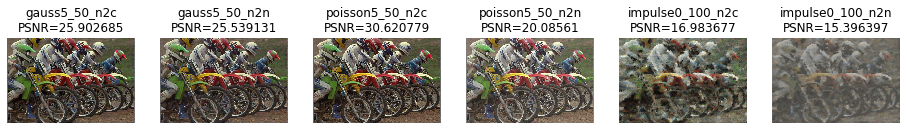

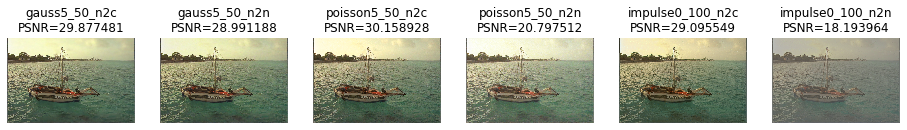

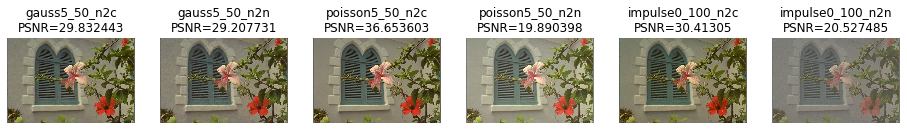

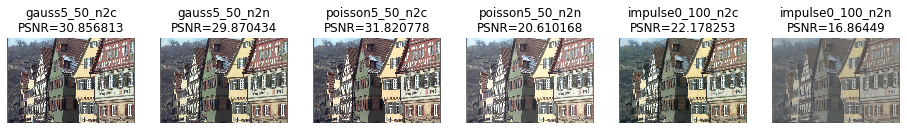

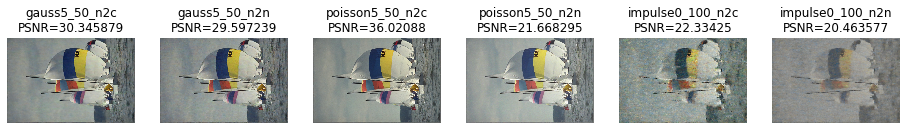

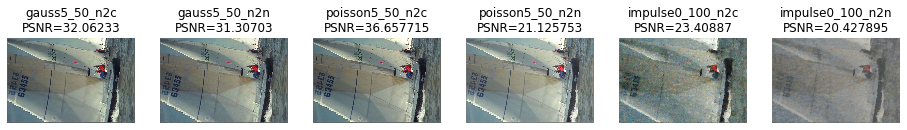

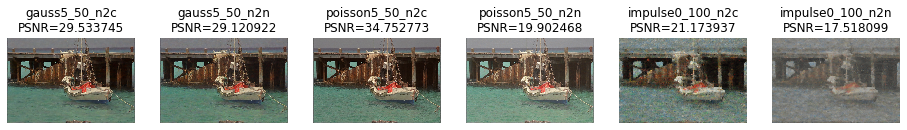

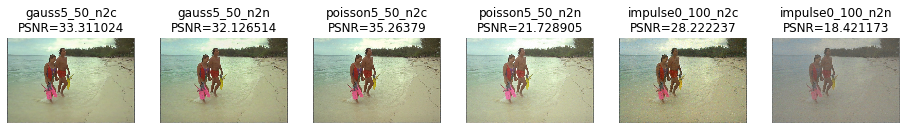

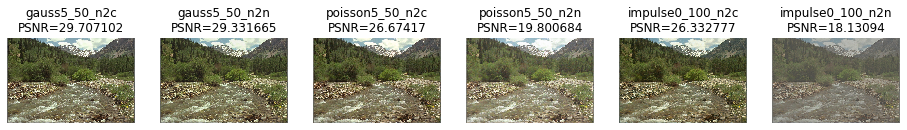

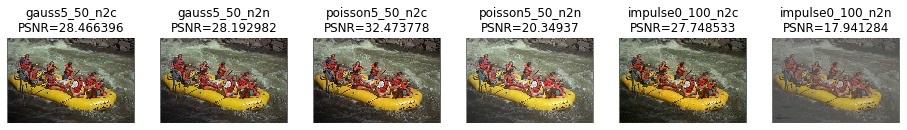

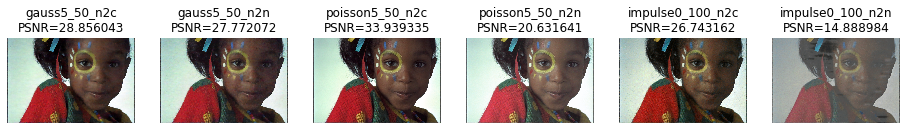

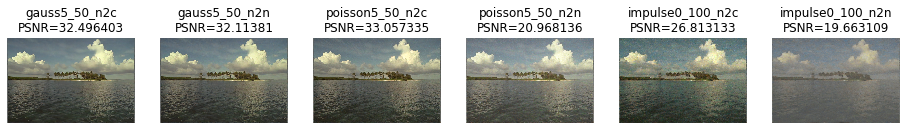

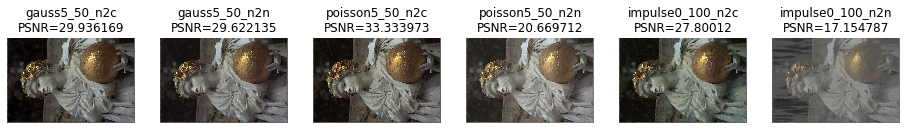

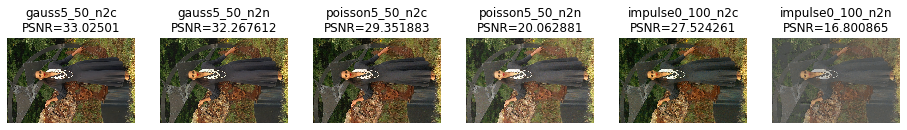

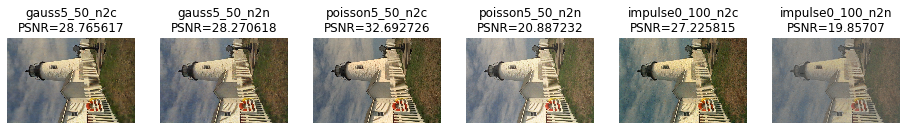

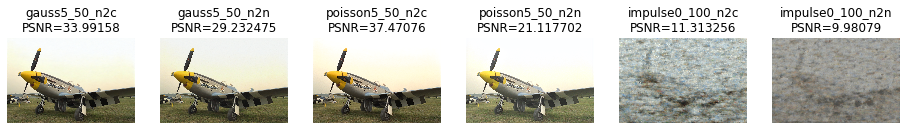

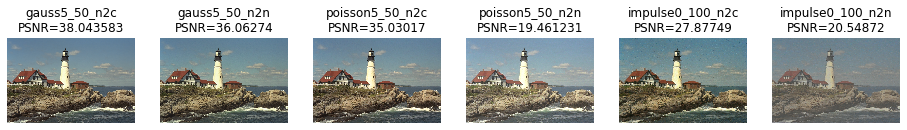

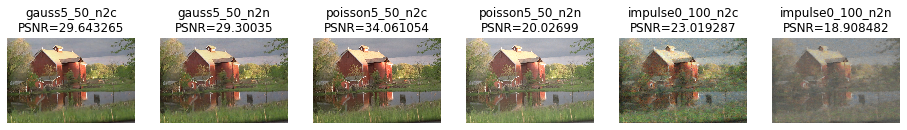

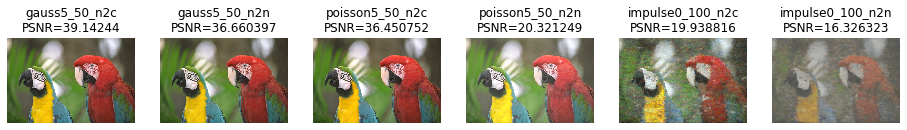

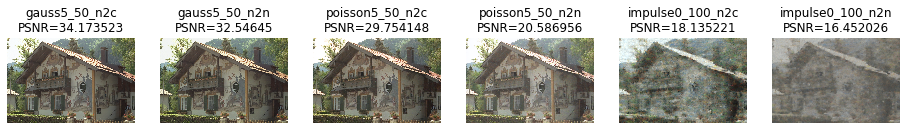

In [36]:
# Plot denoised images from all models
for i in range(0, len(x_val)):
    fig, axes = plt.subplots(1, 6)
    fig.set_size_inches(16, 16)
    
    axes[0].imshow(denoised_images_g_n2c[i])
    axes[0].set_title(all_results_index[0] +'\nPSNR='+str(PSNR(x_val[i], denoised_images_g_n2c[i]).numpy()))
    axes[1].imshow(denoised_images_g_n2n[i])
    axes[1].set_title(all_results_index[1] +'\nPSNR='+str(PSNR(x_val[i], denoised_images_g_n2n[i]).numpy()))
    axes[2].imshow(denoised_images_p_n2c[i])
    axes[2].set_title(all_results_index[2] +'\nPSNR='+str(PSNR(x_val[i], denoised_images_p_n2c[i]).numpy()))
    axes[3].imshow(denoised_images_p_n2n[i])
    axes[3].set_title(all_results_index[3] +'\nPSNR='+str(PSNR(x_val[i], denoised_images_p_n2n[i]).numpy()))
    axes[4].imshow(denoised_images_i_n2c[i])
    axes[4].set_title(all_results_index[4] +'\nPSNR='+str(PSNR(x_val[i], denoised_images_i_n2c[i]).numpy()))
    axes[5].imshow(denoised_images_i_n2n[i])
    axes[5].set_title(all_results_index[5] +'\nPSNR='+str(PSNR(x_val[i], denoised_images_i_n2n[i]).numpy()))
    axes[0].axis('off'); axes[1].axis('off'); axes[2].axis('off'); axes[3].axis('off'); axes[4].axis('off'); axes[5].axis('off')
    plt.show();